In [12]:
import torch
from torch import nn, optim
from torchsummary import summary
from torchvision.utils import make_grid

import os
import imageio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
def pil_to_np_array(pil_image):
    ar = np.array(pil_image)
    if len(ar.shape) == 3:
        ar = ar.transpose(2,0,1)
    else:
        ar = ar[None, ...]
    return ar.astype(np.float32) / 255.

def np_to_torch_array(np_array):
    return torch.from_numpy(np_array)[None, :]

def torch_to_np_array(torch_array):
    return torch_array.detach().cpu().numpy()[0]

def read_image(path, image_size = -1):
    pil_image = Image.open(path)
    return pil_image

def save_image(np_array, step):
    pil_image = Image.fromarray((np_array * 255.0).transpose(1, 2, 0).astype('uint8'), 'RGB')
    pil_image.save(f'{str(step).zfill(len(str(TRAINING_STEPS)))}.png')

def get_image_grid(images, nrow = 3):
    torch_images = [torch.from_numpy(x) for x in images]
    grid = make_grid(torch_images, nrow)
    return grid.numpy()
    
def visualize_sample(*images_np, nrow = 3, size_factor = 10):
    c = max(x.shape[0] for x in images_np)
    images_np = [x if (x.shape[0] == c) else np.concatenate([x, x, x], axis=0) for x in images_np]
    grid = get_image_grid(images_np, nrow)
    plt.figure(figsize = (len(images_np) + size_factor, 12 + size_factor))
    plt.axis('off')
    plt.imshow(grid.transpose(1, 2, 0))
    plt.show()

In [3]:
DTYPE = torch.cuda.FloatTensor
INPUT_DEPTH = 32
LR = 0.01 
TRAINING_STEPS = 10000
SHOW_STEP = 50
REG_NOISE = 0.03

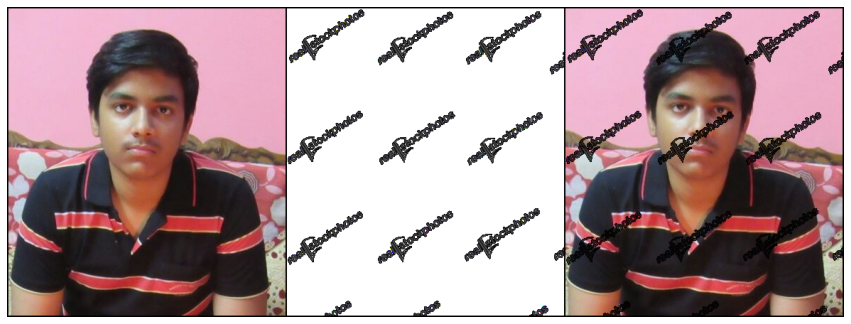

In [4]:
image_path  = os.path.join('me.jpg')
watermark_path = os.path.join('watermark.png')

image_pil = read_image(image_path)
image_pil = image_pil.convert('RGB')

image_mask_pil = read_image(watermark_path)
image_mask_pil = image_mask_pil.convert('RGB')
image_mask_pil = image_mask_pil.resize((image_pil.size[0], image_pil.size[1]))

image_np = pil_to_np_array(image_pil)
image_mask_np = pil_to_np_array(image_mask_pil)
image_mask_np[image_mask_np == 0.0] = 1.0

image_mask_var = np_to_torch_array(image_mask_np).type(DTYPE)

visualize_sample(image_np, image_mask_np, image_mask_np * image_np, nrow = 3, size_factor = 12)

In [5]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride = 1, bias = False):
        super(Conv2dBlock, self).__init__()

        self.model = nn.Sequential(
            nn.ReflectionPad2d(int((kernel_size - 1) / 2)),
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding = 0, bias = bias),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2)
        )

    def forward(self, x):
        return self.model(x)

class Concat(nn.Module):
    def __init__(self, dim, *args):
        super(Concat, self).__init__()
        self.dim = dim

        for idx, module in enumerate(args):
            self.add_module(str(idx), module)

    def forward(self, input):
        inputs = []
        for module in self._modules.values():
            inputs.append(module(input))

        inputs_shapes2 = [x.shape[2] for x in inputs]
        inputs_shapes3 = [x.shape[3] for x in inputs]        

        if np.all(np.array(inputs_shapes2) == min(inputs_shapes2)) and np.all(np.array(inputs_shapes3) == min(inputs_shapes3)):
            inputs_ = inputs
        else:
            target_shape2 = min(inputs_shapes2)
            target_shape3 = min(inputs_shapes3)

            inputs_ = []
            for inp in inputs: 
                diff2 = (inp.size(2) - target_shape2) // 2 
                diff3 = (inp.size(3) - target_shape3) // 2 
                inputs_.append(inp[:, :, diff2: diff2 + target_shape2, diff3:diff3 + target_shape3])

        return torch.cat(inputs_, dim=self.dim)

    def __len__(self):
        return len(self._modules)

In [6]:
class SkipEncoderDecoder(nn.Module):
    def __init__(self, input_depth, num_channels_down = [128] * 5, num_channels_up = [128] * 5, num_channels_skip = [128] * 5):
        super(SkipEncoderDecoder, self).__init__()

        self.model = nn.Sequential()
        model_tmp = self.model

        for i in range(len(num_channels_down)):

            deeper = nn.Sequential()
            skip = nn.Sequential()

            if num_channels_skip[i] != 0:
                model_tmp.add_module(str(len(model_tmp) + 1), Concat(1, skip, deeper))
            else:
                model_tmp.add_module(str(len(model_tmp) + 1), deeper)
            
            model_tmp.add_module(str(len(model_tmp) + 1), nn.BatchNorm2d(num_channels_skip[i] + (num_channels_up[i + 1] if i < (len(num_channels_down) - 1) else num_channels_down[i])))

            if num_channels_skip[i] != 0:
                skip.add_module(str(len(skip) + 1), Conv2dBlock(input_depth, num_channels_skip[i], 1, bias = False))
                
            deeper.add_module(str(len(deeper) + 1), Conv2dBlock(input_depth, num_channels_down[i], 3, 2, bias = False))
            deeper.add_module(str(len(deeper) + 1), Conv2dBlock(num_channels_down[i], num_channels_down[i], 3, bias = False))

            deeper_main = nn.Sequential()

            if i == len(num_channels_down) - 1:
                k = num_channels_down[i]
            else:
                deeper.add_module(str(len(deeper) + 1), deeper_main)
                k = num_channels_up[i + 1]

            deeper.add_module(str(len(deeper) + 1), nn.Upsample(scale_factor = 2, mode = 'nearest'))

            model_tmp.add_module(str(len(model_tmp) + 1), Conv2dBlock(num_channels_skip[i] + k, num_channels_up[i], 3, 1, bias = False))
            model_tmp.add_module(str(len(model_tmp) + 1), Conv2dBlock(num_channels_up[i], num_channels_up[i], 1, bias = False))

            input_depth = num_channels_down[i]
            model_tmp = deeper_main

        self.model.add_module(str(len(self.model) + 1), nn.Conv2d(num_channels_up[0], 3, 1, bias = True))
        self.model.add_module(str(len(self.model) + 1), nn.Sigmoid())
    
    def forward(self, x):
        return self.model(x)

def input_noise(input_depth, spatial_size, scale = 1./10):
    shape = [1, input_depth, spatial_size[0], spatial_size[1]]
    return torch.rand(*shape) * scale

In [7]:
generator = SkipEncoderDecoder(
    INPUT_DEPTH,
    num_channels_down = [128] * 5,
    num_channels_up = [128] * 5,
    num_channels_skip = [128] * 5
).type(DTYPE)
generator_input = input_noise(INPUT_DEPTH, image_np.shape[1:]).type(DTYPE)
summary(generator, generator_input.shape[1:])

objective = torch.nn.MSELoss().type(DTYPE)
optimizer = optim.Adam(generator.parameters(), LR)

image_var = np_to_torch_array(image_np).type(DTYPE)
mask_var = np_to_torch_array(image_mask_np).type(DTYPE)

generator_input_saved = generator_input.detach().clone()
noise = generator_input.detach().clone()

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad2d-1         [-1, 32, 432, 390]               0
            Conv2d-2        [-1, 128, 432, 390]           4,096
       BatchNorm2d-3        [-1, 128, 432, 390]             256
         LeakyReLU-4        [-1, 128, 432, 390]               0
       Conv2dBlock-5        [-1, 128, 432, 390]               0
   ReflectionPad2d-6         [-1, 32, 434, 392]               0
            Conv2d-7        [-1, 128, 216, 195]          36,864
       BatchNorm2d-8        [-1, 128, 216, 195]             256
         LeakyReLU-9        [-1, 128, 216, 195]               0
      Conv2dBlock-10        [-1, 128, 216, 195]               0
  ReflectionPad2d-11        [-1, 128, 218, 197]               0
           Conv2d-12        [-1, 128, 216, 195]         147,456
      BatchNorm2d-13        [-1, 128, 216, 195]             256
        LeakyReLU-14        [-1, 128, 2

In [ ]:
for step in range(TRAINING_STEPS):
    optimizer.zero_grad()
    generator_input = generator_input_saved

    if REG_NOISE > 0:
        generator_input = generator_input_saved + (noise.normal_() * REG_NOISE)
        
    out = generator(generator_input)
   
    loss = objective(out * mask_var, image_var * mask_var)
    loss.backward()
        
    if step % SHOW_STEP == 0:
        output_image = torch_to_np_array(out)
        save_image(output_image, step)
        visualize_sample(output_image, nrow = 1, size_factor = 5)
        print(f'Step: {step} | Loss: {loss.item()}')
        
    optimizer.step()

In [ ]:
import glob

progress_images = sorted(glob.glob('*.png'))
images = []

for image_path in progress_images:
    images.append(imageio.imread(image_path))
imageio.mimsave('progress.gif', images, fps = 8)